In [1]:
from matplotlib import pyplot as plt
import tfim_1d
from Ham_generator import *
from qcels import *
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService as QRS
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.circuit.library import Initialize
import matplotlib
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 10

In [2]:
num_sites = 4

#TFIM parameters
J_T = 1.0
g_T = 4

#HSM parameters
J_H = 4
g_H = 0

#Hubb parameters
t_H = 1
U_H = 10

Hubbard Model


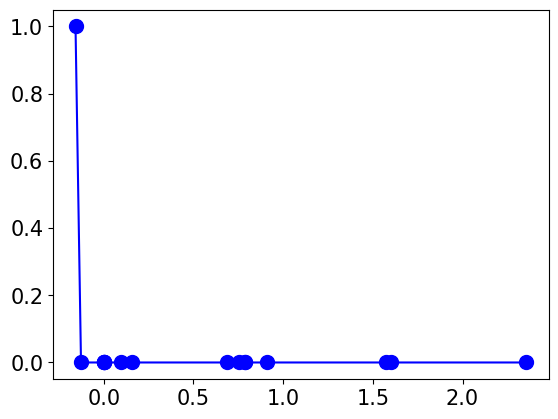

In [5]:
# T (TFIM), H (HSM), B (Hubbard)
model_type = 'B'

if model_type[0].upper() == 'T':
    mn = 'TFIM'
    print('Transverse Field Ising Model')

    # calculate the ground state with g = 1
    ham0 = tfim_1d.generate_ham(num_sites, J_T, 1.0)
    ground_state_0 = ham0.eigh(subset_by_index = (0,0))[1][:,0] # g = 1 ground state


    # plot original spectrum
    ham = tfim_1d.generate_ham(num_sites, J_T, g_T)
    eigenenergies, eigenstates = ham.eigh()
    ground_state = eigenstates[:,0]
    population_raw = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2
    plt.plot(eigenenergies, population_raw, 'b-o')
    plt.show()
    print(eigenenergies[0])

    old_ham = ham

    # create modified spectrum
    ham = modify_spectrum(old_ham)
    eigenenergies, eigenstates = eigh(ham)

    ground_state = eigenstates[:,0]
    population = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2
    plt.plot(eigenenergies, population, 'b-o')
    plt.show()
if model_type[0].upper() == 'H':
    mn = 'HSM'
    print('Heisenberg Spin Model')

    ham = create_hamiltonian(num_sites, 'SPIN', ham_shift, g = g_H, J=J_H, show_steps=False)
    spin_energies, spin_states = eigh(ham)
    ground_state = spin_states[:,0]

    pop = np.abs(np.dot(spin_states.conj().T, ground_state))**2

    plt.plot(spin_energies, pop, 'b-o')
    plt.show()

if model_type[0].upper() == 'B':
    mn = "HUBB"
    print('Hubbard Model')

    ham = create_hamiltonian(num_sites, 'HUBB', ham_shift, t = t_H, U=U_H, x = num_sites/2, y = num_sites/2, show_steps=False)

    eigen_energies, eigen_states = eigh(ham)
    ground_state = eigen_states[:,0]

    popp = np.abs(np.dot(eigen_states.conj().T, ground_state))**2

    plt.plot(eigen_energies, popp, 'b-o')
    plt.show()

In [7]:
print(eigen_energies[0])

-0.15707963267948968


In [8]:
computation_type = 'S'
output_file = True
p0_array            = np.array([0.6, 0.8]) # initial overlap with the first eigenvector
deltas              = 1 - np.sqrt(p0_array)
trials              = 5 # number of comparisions each test (circuit depths)
tests               = 1
err_threshold       = 0.01
T0                  = 100

# QCELS variables
time_steps          = 20
#epsilons            = np.array([0.5, 0.1, 0.02, 0.009, 0.003, 0.001, 0.0005, 0.0002, 0.00009, 0.00004])
epsilons            = np.array([0.5, 0.02, 0.003, 0.0005, 0.00009])
iterations          = [int(np.log2(1/i) + 1) for i in epsilons]
err_QCELS           = np.zeros((len(p0_array),trials))
est_QCELS           = np.zeros((len(p0_array),trials))
cost_list_avg_QCELS = np.zeros((len(p0_array),trials))
rate_success_QCELS  = np.zeros((len(p0_array),trials))
max_T_QCELS         = np.zeros((len(p0_array),trials))

In [9]:
# initialization: S (Quantum Simulation), or R (Quantum Hardware)

if computation_type[0].upper() == 'S':
    print("\nQUANTUM SIMULATION SELECTED\n")

    backend = AerSimulator()
    data_name = "Q_Sim"

if computation_type[0].upper() == 'R':
    print("\nQUANTUM HARDWARE SELECTED\n")    
    
    # save qiskit API token for later use
    api_token = input("Enter API Token:")
    service = QRS(channel = 'ibm_quantum', instance='rpi-rensselaer/research/faulsf', token = api_token)
    backend = service.backend('ibm_rensselaer')
    data_name = "Q_Real"

if output_file:
    outfile = open("Output/"+str(data_name)+"_"+str(mn)+"_trans.txt", 'w')



QUANTUM SIMULATION SELECTED



In [10]:
ansatz = []
for p in range(len(p0_array)):
    psi = ground_state

    # Generate a random vector orthogonal to psi
    random_vec = np.random.randn(2**num_sites) + 1j * np.random.randn(2**num_sites)
    random_vec -= np.vdot(psi, random_vec) * psi  # Make orthogonal to psi
    random_vec /= np.linalg.norm(random_vec)  # Normalize

    # Construct psi with the required squared overlap
    overlap_squared = p0_array[p]
    phi = np.sqrt(overlap_squared) * psi + np.sqrt(1 - overlap_squared) * random_vec

    print(np.abs(np.vdot(psi, phi))**2)
    ansatz.append(phi)

0.6000000000000002
0.8000000000000002


In [11]:
# Transpiles circuits
for p in range(len(p0_array)):
    p0=p0_array[p]
    n_success_QCELS= np.zeros(trials)
    n_success_QPE= np.zeros(trials)

    print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")")

    if output_file: print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")", file = outfile)

    print("  Generating QCELS circuits", "(p0="+str(p0)+")")

    #spectrum, population = generate_spectrum_population(eigenenergies, population_raw, [p0])

    #------------------QCELS-----------------
    Nsample = 100 # number of samples for constructing the loss function

    for trial in range(trials):
        print("    Transpiling QCELS", "("+str(trial+1)+"/"+str(trials)+")")
        epsilon = epsilons[trial]

        if output_file: print("    Transpiling QCELS", "("+str(trial+1)+"/"+str(trials)+")", file = outfile, flush = True)
        T = 1/epsilon
        for j in range(iterations[trial] + 1):
            tau = get_tau(j, time_steps, iterations[trial], T)
            qcs_QCELS = []
            #unitaries = (generate_TFIM_gates(num_sites, time_steps, tau, g_T, '../../../f3cpp'))
            for data_pair in range(time_steps):
                t = tau*data_pair
                mat = expm(-1j*ham*t)
                controlled_U = UnitaryGate(mat).control(annotated="yes")
                #qcs_QCELS.append(create_HT_circuit(num_sites, unitaries[data_pair], W = 'Re', backend = backend))
                #qcs_QCELS.append(create_HT_circuit(num_sites, unitaries[data_pair], W = 'Im', backend = backend))
                qcs_QCELS.append(create_HT_circuit(num_sites, controlled_U, W = 'Re', backend = backend, init_state = ansatz[p]))
                qcs_QCELS.append(create_HT_circuit(num_sites, controlled_U, W = 'Im', backend = backend, init_state = ansatz[p]))
            with open('Transpiled_Circuits/QCELS_p0='+str(p0)+'_Trial'+str(trial)+'_Iter='+str(j)+'.qpy', 'wb') as f:
                qiskit.qpy.dump(qcs_QCELS, f)
    print('Finished transpiling for QCELS ', "(p0="+str(p0)+")")


Testing p0 = 0.6 (1/2)
  Generating QCELS circuits (p0=0.6)
    Transpiling QCELS (1/5)
    Transpiling QCELS (2/5)


KeyboardInterrupt: 

In [21]:
# Loads transpiled circuits
QCELS_depths = []

qcs_QCELS = []

for p in range(len(p0_array)):
    p0 = p0_array[p]
    QCELS_depths.append([])
    for test in range(tests):
        QCELS_depths[p].append([])
        for trial in range(trials):
            depth = 0
            print('Loading QCELS data ('+str(trial+1)+'/'+str(trials)+')')
            for i in range(iterations[trial] + 1):
                with open('Transpiled_Circuits/QCELS_p0='+str(p0)+'_Trial'+str(trial)+'_Iter='+str(i)+'.qpy', 'rb') as f:
                    circs = qiskit.qpy.load(f)
                    for time_step in range(time_steps):
                        depth += circs[time_step].depth() 
                    qcs_QCELS.append(circs)

            QCELS_depths[p][test].append(depth)

qcs_QCELS = sum(qcs_QCELS, []) # flatten list

Loading QCELS data (1/5)
Loading QCELS data (2/5)
Loading QCELS data (3/5)
Loading QCELS data (4/5)
Loading QCELS data (5/5)
Loading QCELS data (1/5)
Loading QCELS data (2/5)
Loading QCELS data (3/5)
Loading QCELS data (4/5)
Loading QCELS data (5/5)


In [38]:
print(QCELS_depths)

[[[88465, 205581, 293478, 351738, 440033]], [[88465, 205581, 293478, 351738, 440033]]]


In [22]:
num_splits = len(p0_array)*tests
split = int(len(qcs_QCELS)/num_splits)

qcs_QCELS_circuits = []
for i in range(num_splits):
    qcs_QCELS_circuits.append(qcs_QCELS[i*split:(i+1)*split])

In [23]:
# Runs loaded circuits
print('Running transpiled circuits')
sampler = Sampler(backend)
jobs = []
results = []
for i in range(num_splits):
    job = sampler.run(qcs_QCELS_circuits[i], shots = T0)
    result = job.result()
    jobs.append(job)
    results.append(result)

Running transpiled circuits


In [24]:
results = flatten(results)

In [25]:
Z_ests = []
QCELS_times = []

for p in range(len(p0_array)):
    Z_ests.append([])
    QCELS_times.append([])
    for test in range(tests):
        Z_ests[p].append([])
        QCELS_times[p].append([])
        for trial in range(trials):
            exec_time = 0
            Z_ests[p][test].append([])
            for iter in range(iterations[trial] + 1):
                Z_ests[p][test][trial].append([])
                for time_step in range(time_steps):
                    index = time_step*2 + iter*time_steps*2 + (sum(iterations[0:trial])+trial)*time_steps*2 + test*(sum(iterations)+len(iterations))*time_steps*2 + p*tests*(sum(iterations)+len(iterations))*time_steps*2
                    raw_data_re = results[index].data
                    counts_re = raw_data_re[list(raw_data_re.keys())[0]].get_counts()
                    raw_data_im = results[index + 1].data
                    counts_im = raw_data_im[list(raw_data_im.keys())[0]].get_counts()
                    exec_time += (0 + 1)

                    re_p0 = im_p0 = 0
                    if counts_re.get('0') is not None:
                        re_p0 = counts_re['0']/T0
                    if counts_im.get('0') is not None:
                        im_p0 = counts_im['0']/T0
                    
                    Re = 2*re_p0-1
                    Im = 2*im_p0-1 

                    Angle = np.arccos(Re)
                    if  np.arcsin(Im)<0:
                        Phase = 2*np.pi - Angle
                    else:
                        Phase = Angle

                    Z_est = complex(np.cos(Phase),np.sin(Phase))
                    Z_ests[p][test][trial][iter].append(Z_est)
            QCELS_times[p][test].append(exec_time)

In [26]:
lambda_prior = -ham_shift
lambda_prior = eigen_energies[0]
#print(lambda_prior)

In [27]:
if output_file:
    outfile = open("Output/"+str(data_name)+"_"+str(mn)+"_run.txt", 'w')

for p in range(len(p0_array)):
    p0=p0_array[p]
    n_success_QCELS= np.zeros(trials)
    n_success_QPE= np.zeros(trials)

    print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")")

    if output_file: print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")", file = outfile)

    for test in range(tests):

        print("  Generating QCELS and QPE data", "(p0="+str(p0)+")","("+str(test+1)+"/"+str(tests)+")")

        #spectrum, population = generate_spectrum_population(eigenenergies, population_raw, [p0])

        #------------------QCELS-----------------
        Nsample = 100 # number of samples for constructing the loss function

        for trial in range(trials):
            print("    Running QCELS", "("+str(trial+1)+"/"+str(trials)+")")

            if output_file: print("    Running QCELS", "("+str(trial+1)+"/"+str(trials)+")", file = outfile, flush = True)
            epsilon = epsilons[trial]
            T = 1/epsilon
            #lambda_prior = spectrum[0]
            ground_energy_estimate_QCELS, cosT_depth_list_this = qcels_largeoverlap_new(Z_ests[p][test][trial], time_steps, lambda_prior, T)
            #ground_energy_estimate_QCELS, cosT_depth_list_this, max_T_QCELS_this = qcels_largeoverlap()
            
            #cosT_depth_list_this = QCELS_depths[p][test][trial]
            max_T_QCELS_this = 0

            print("      Estimated ground state energy =", ground_energy_estimate_QCELS)
            if output_file: print("      Estimated ground state energy =", ground_energy_estimate_QCELS.x[2], file = outfile)

            est_this_run_QCELS = ground_energy_estimate_QCELS.x[2]
            err_this_run_QCELS = np.abs(ground_energy_estimate_QCELS.x[2] - lambda_prior)
            err_QCELS[p,trial] = err_QCELS[p,trial]+np.abs(err_this_run_QCELS)
            est_QCELS[p,trial] = est_QCELS[p,trial] + est_this_run_QCELS
            cost_list_avg_QCELS[p,trial]=cost_list_avg_QCELS[p,trial]+cosT_depth_list_this
            max_T_QCELS[p,trial]=max(max_T_QCELS[p,trial],max_T_QCELS_this)

            if np.abs(err_this_run_QCELS)<err_threshold:
                n_success_QCELS[trial]+=1

        print("    Finished QCELS data\n")
        if output_file: print("    Finished QCELS data\n", file = outfile)

    rate_success_QCELS[p,:] = n_success_QCELS[:]/tests
    err_QCELS[p,:] = err_QCELS[p,:]/tests
    est_QCELS[p,:] = est_QCELS[p,:]/tests
    #cost_list_avg_QCELS[p,:]=cost_list_avg_QCELS[p,:]/tests
    cost_list_avg_QCELS[p,:]=2*cost_list_avg_QCELS[p,:]/tests # observables instead of time steps



Testing p0 = 0.6 (1/2)
  Generating QCELS and QPE data (p0=0.6) (1/1)
    Running QCELS (1/5)
      Preprocessing
      Starting Iteration (1/2)
      Starting Iteration (2/2)
      Finished Iterations
      Estimated ground state energy =  message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.27425922849260864
       x: [ 6.772e-01 -5.163e-01 -9.559e-01]
     nit: 13
     jac: [-5.371e-04  3.253e-04  1.493e-04]
    nfev: 56
    njev: 13
    Running QCELS (2/5)
      Preprocessing
      Starting Iteration (1/6)
      Starting Iteration (2/6)
      Starting Iteration (3/6)
      Starting Iteration (4/6)
      Starting Iteration (5/6)
      Starting Iteration (6/6)
      Finished Iterations
      Estimated ground state energy =  message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.33373305642796697
       x: [ 6.581e-01 -4.830e-01 -2.575e-01]
     nit: 7
     jac: [ 1.302e-04 -8.259e-05 -2.442e-03]
    nfev: 34
    njev: 7
  

In [28]:
#model_type = 'T'
if model_type[0].upper() == 'T':
    np.savez('Data/'+data_name+'_result_TFIM_'+str(num_sites)+'sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS,name5=est_QCELS)
    #np.savez('Data/'+data_name+'_TFIM_8sites_data',name1=spectrum,name2=population,name3=ground_energy_estimate_QCELS.x[0],
            #name4=ground_energy_estimate_QCELS.x[1],name5=ground_energy_estimate_QCELS.x[2])
if model_type[0].upper() == 'H':
    np.savez('Data/'+data_name+'_result_HSM_'+str(num_sites)+'sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS,name5=est_QCELS)
if model_type[0].upper() == 'B':
    np.savez('Data/'+data_name+'_result_HUBB_'+str(num_sites)+'sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS,name5=est_QCELS)

print("Saved data to files starting with", data_name)
if output_file: print("Saved data to files starting with", data_name, file = outfile, flush=True)
outfile.close()
if output_file: print("Saved output to file ", "Output/"+str(data_name)+".txt")


Saved data to files starting with Q_Sim
Saved output to file  Output/Q_Sim.txt
